# Clustering
In this notebook, three different clustering methods are compared and visualized.

## Import Libraries and Data

In [68]:
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn import manifold

import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline
plt.rcParams['figure.figsize'] = (11, 7)
plt.style.use('ggplot')

cleanData = pd.read_csv("CleanData.csv")
cleanData = cleanData.drop("Unnamed: 0", 1)
cleanData.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,higher_num,internet_num,romantic_num,paid_port_num,paid_math_num,paid_num,absences,G1,G2,G3
0,GP,F,18.0,U,GT3,A,4.0,4.0,at_home,teacher,...,0,1,1,1.0,1.0,1,5.0,2.5,8.5,8.5
1,GP,F,17.0,U,GT3,T,1.0,1.0,at_home,other,...,0,0,1,1.0,1.0,1,3.0,7.0,8.0,8.5
2,GP,F,15.0,U,LE3,T,1.0,1.0,at_home,other,...,0,0,1,1.0,0.0,1,3.0,6.0,6.5,6.0
3,GP,F,15.0,U,GT3,T,4.0,2.0,health,services,...,0,0,0,1.0,0.0,1,1.0,14.5,14.0,14.5
4,GP,F,16.0,U,GT3,T,3.0,3.0,other,other,...,0,1,1,1.0,0.0,1,2.0,8.5,11.5,11.5


In [2]:
# Lists of subsets of columns to use to make analysis easier

# All columns
allCols = list(cleanData.columns.values)   

# Columns with numbers
numCols = ['Dalc', 'Fedu', 'G1', 'G2', 'G3', 'Medu', 'Walc', 'absences', 'age', 
                  'failures', 'famrel', 'freetime', 'goout', 'health', 'math', 
                  'port', 'studytime', 'traveltime', 'school_num', 'sex_num','address_num', 
                  'famsize_num', 'Pstatus_num', 'Mjob_num', 'Fjob_num','reason_num', 
                  'guardian_num', 'schoolsup_num', 'famsup_num', 'activities_num','nursery_num', 
                  'higher_num', 'internet_num', 'romantic_num', 'paid_num']

# useCols will be the variable used for analysis from here on out. This way it can be switched easily
# if a different subset of columns is to be used or tested
useCols = numCols

useData = cleanData[numCols]

## k-Means Clustering
In this next section we'll perform k-Means using 1-10 clusters and plot the inertia.

Number of clusters = 1 completed
Number of clusters = 2 completed
Number of clusters = 3 completed
Number of clusters = 4 completed
Number of clusters = 5 completed
Number of clusters = 6 completed
Number of clusters = 7 completed
Number of clusters = 8 completed
Number of clusters = 9 completed
Number of clusters = 10 completed
Number of clusters = 11 completed
Number of clusters = 12 completed
Number of clusters = 13 completed
Number of clusters = 14 completed
Number of clusters = 15 completed


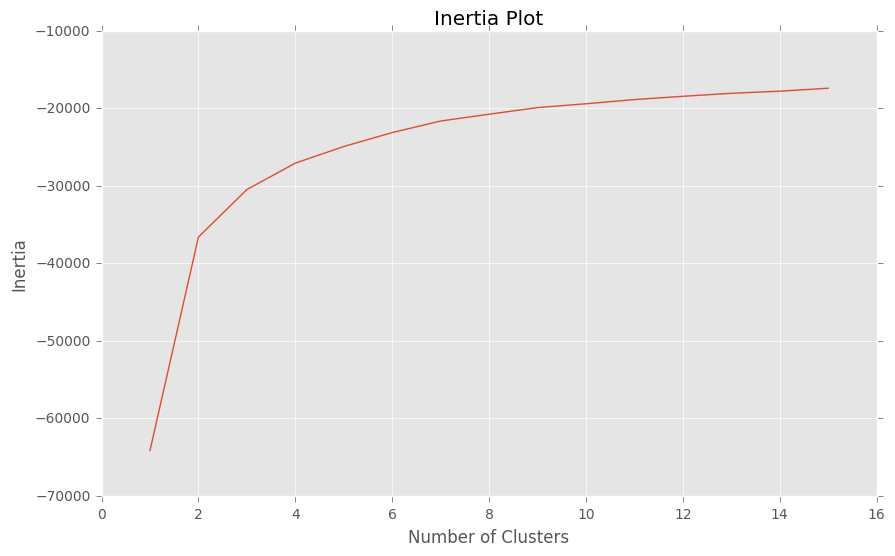

In [9]:
kVals = []
scores = []
labels = []
numClusters = 15

for i in range(1,numClusters+1):
    model = KMeans(n_clusters=i)
    labels.append(model.fit_predict(useData))
    scores.append(model.score(useData))
    kVals.append(i)
    print("Number of clusters =", kVals[-1], "completed")
    
plt.plot(kVals, scores)
plt.ylabel('Inertia')
plt.xlabel('Number of Clusters')
plt.title('Inertia Plot')
plt.show()

1 cluster is obviously performs poorly. But, going to two clusters increases the performance significantly. Let's calculate the silhouette scores for 2 through 8 clusters.

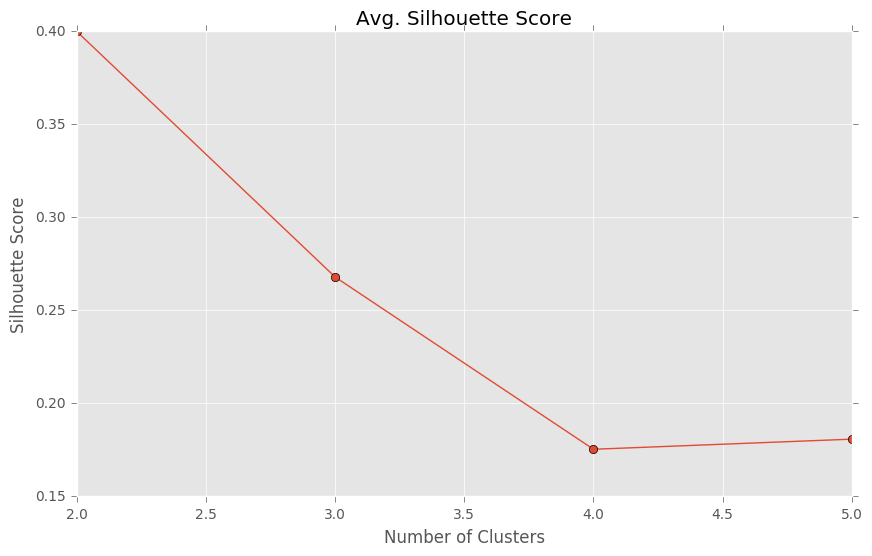

In [15]:
nClusters = []
silAvg = []
for i in range(2,6):
    nClusters.append(i)
    silAvg.append(silhouette_score(useData, labels[i]))
    
plt.plot(nClusters, silAvg, 'o-')
plt.ylabel('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.title('Avg. Silhouette Score')
plt.show()

The closer the silhouette score of a cluster is to +1, the farther that cluster is from other clusters. The average silhouette score gives the average for the silhouette scores for all the clusters. A high average silhouette score is a good indication, but a low one isn't necessarily a bad indication. Maybe there's an 'outlier' cluster? Let's plot the four silhouette plots below. The red dashed line is the average silhouette value for all clusters.

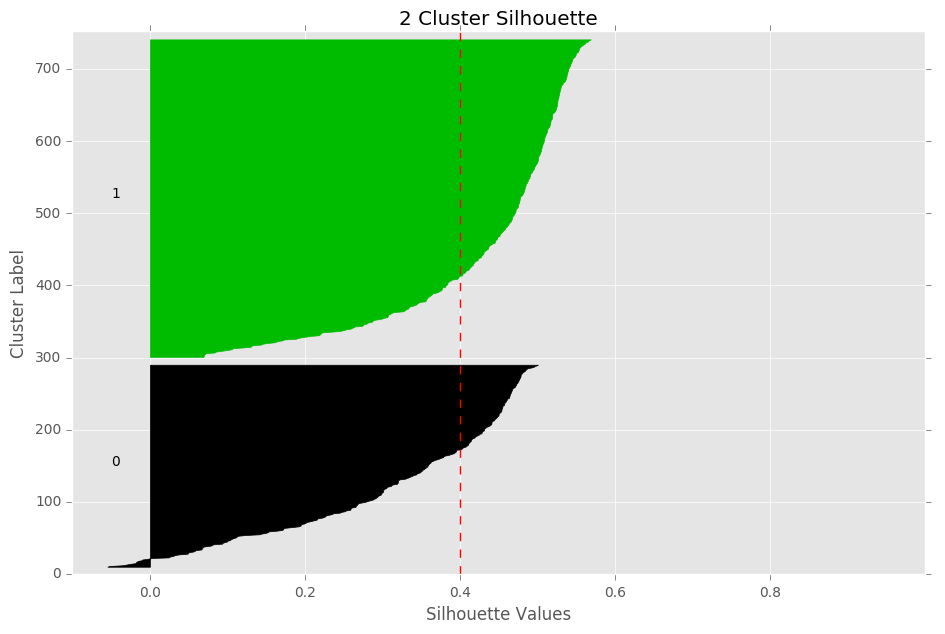

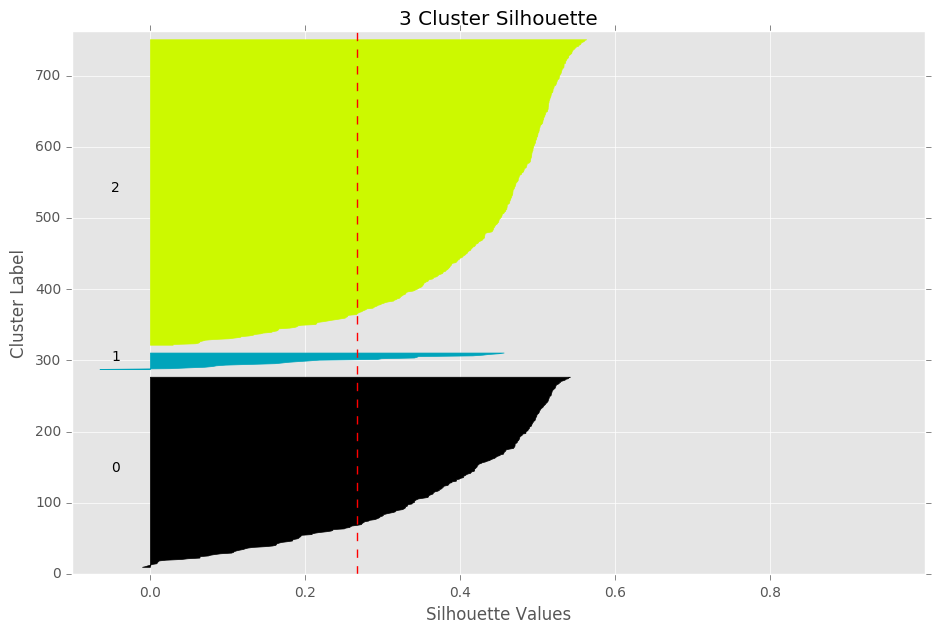

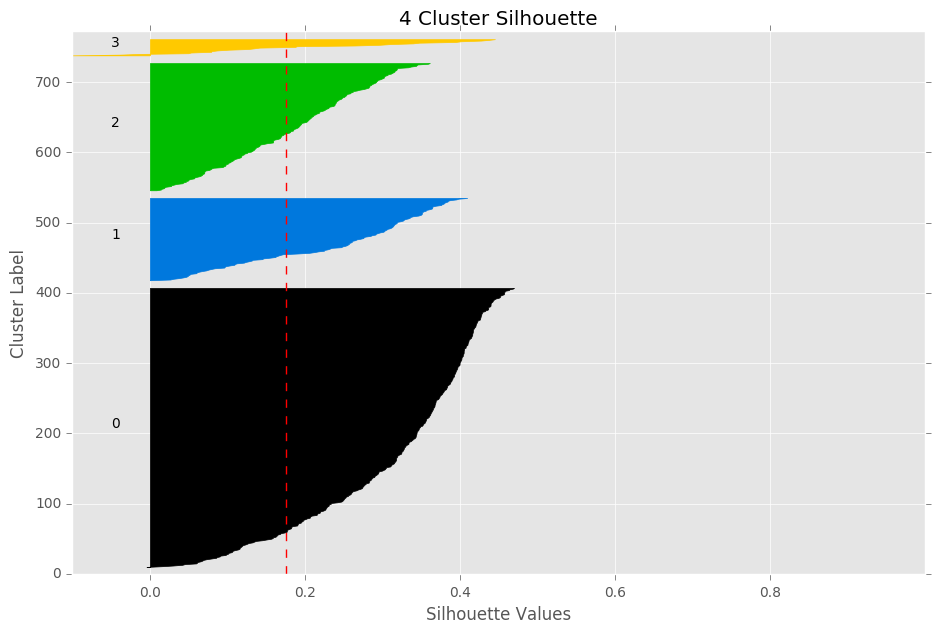

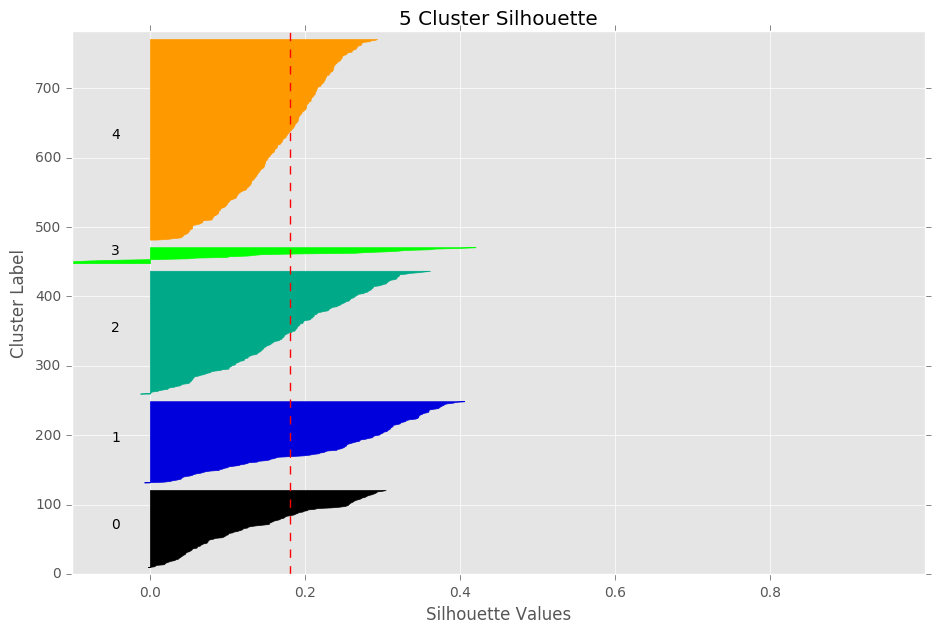

In [50]:
for nClusters in range(2,6):
    fig, ax1 = plt.subplots(1,1)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(useData) + (nClusters + 1) * 10])
    ax1.set_title(str(nClusters)+' Cluster Silhouette')
    ax1.set_xlabel('Silhouette Values')
    ax1.set_ylabel('Cluster Label')
    ax1.axvline(x=silAvg[nClusters-2], color='red', linestyle='--')
    silSamples = silhouette_samples(useData, labels[nClusters-1], metric='euclidean')
    yLower = 10
    for i in range(nClusters):
        silVals = silSamples[labels[nClusters-1] == i]
        silVals.sort()
        sze = silVals.shape[0]
        yUpper = yLower + sze
        color = cm.spectral(float(i) / nClusters)
        ax1.fill_betweenx(np.arange(yLower, yUpper), 0, silVals, facecolor=color, edgecolor=color)
        ax1.text(-0.05, yLower+0.5*sze, str(i))
        yLower = yUpper + 10


The silhouettes are not promising. First, there are no scores that are higher than 0.6 (the ideal is 1). Second, the silhouettes drop quickly - they don't have a nice rectangular shape. This means there's probably a lot of blending between clusters. This could mean that there aren't good clusters, or that k-Means didn't produce good clusters. Let's try hierachical clustering.

## Hierarchical Clustering

In [52]:
numClusters = 6
labels = []
for i in range(1, numClusters):
    model = AgglomerativeClustering(linkage='average', affinity='euclidean', n_clusters=i)
    labels.append(model.fit_predict(useData))
    print("Number of clusters =", i, "completed")

Number of clusters = 1 completed
Number of clusters = 2 completed
Number of clusters = 3 completed
Number of clusters = 4 completed
Number of clusters = 5 completed


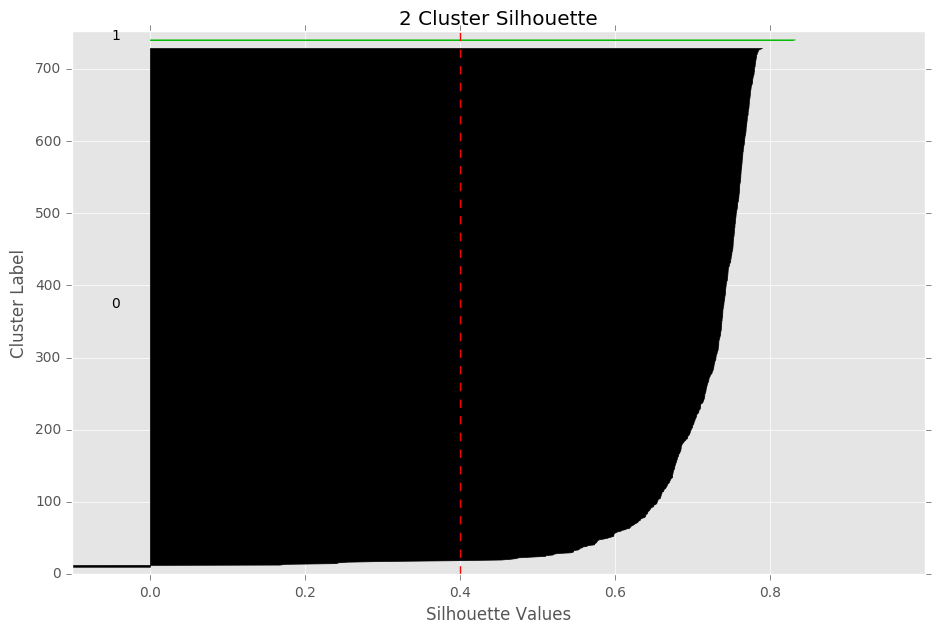

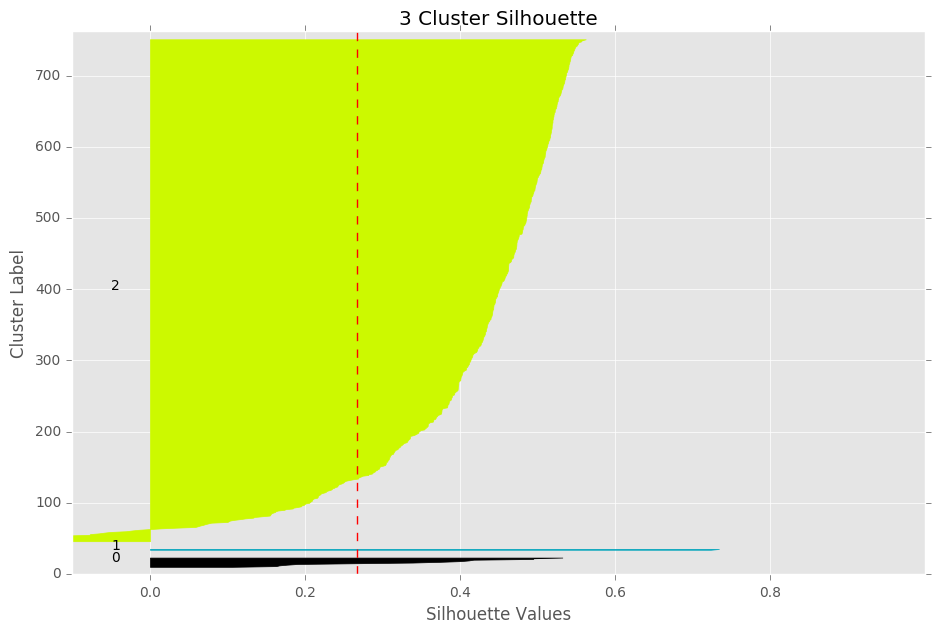

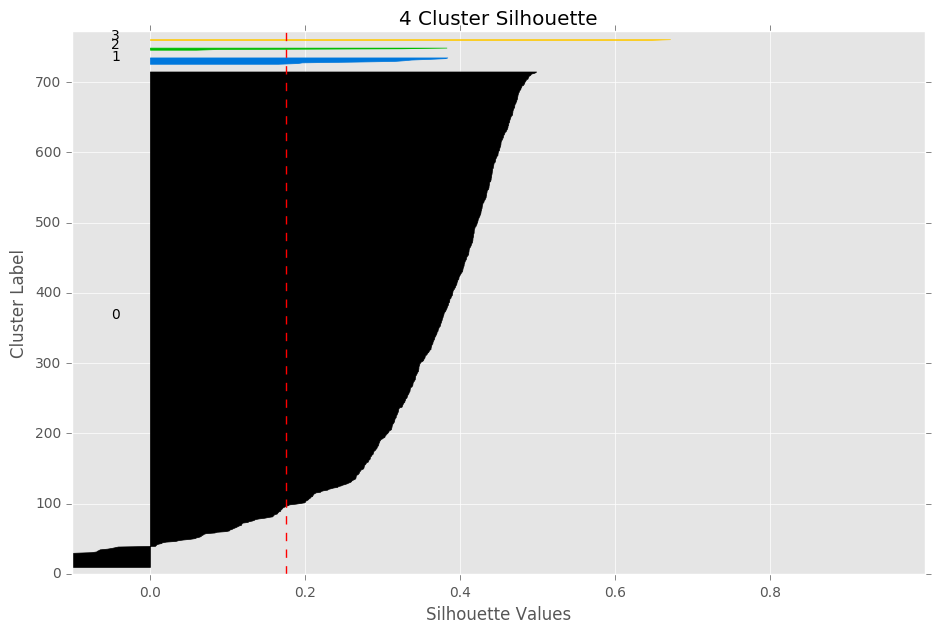

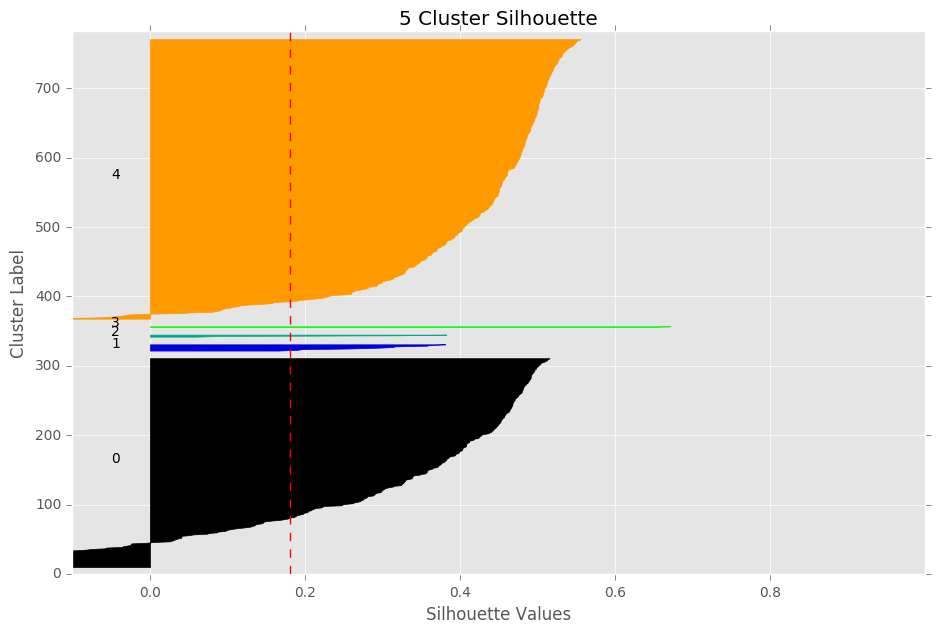

In [54]:
for nClusters in range(2,6):
    fig, ax1 = plt.subplots(1,1)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(useData) + (nClusters + 1) * 10])
    ax1.set_title(str(nClusters)+' Cluster Silhouette')
    ax1.set_xlabel('Silhouette Values')
    ax1.set_ylabel('Cluster Label')
    ax1.axvline(x=silAvg[nClusters-2], color='red', linestyle='--')
    silSamples = silhouette_samples(useData, labels[nClusters-1], metric='euclidean')
    yLower = 10
    for i in range(nClusters):
        silVals = silSamples[labels[nClusters-1] == i]
        silVals.sort()
        sze = silVals.shape[0]
        yUpper = yLower + sze
        color = cm.spectral(float(i) / nClusters)
        ax1.fill_betweenx(np.arange(yLower, yUpper), 0, silVals, facecolor=color, edgecolor=color)
        ax1.text(-0.05, yLower+0.5*sze, str(i))
        yLower = yUpper + 10



This produces interesting results. Agglomerative clustering implies that there's really only one big cluster. At 5 clusters it seems like there's two big clusters but it's probably the one big cluster split into two. Let's try one last advanced clustering algorithm that determines the number of clusters for you, DBSCAN. Default parameters will be used.

## DBSCAN

In [67]:
db = DBSCAN(eps=0.5, min_samples=5).fit(useData)
labels = db.labels_
labels

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

DBSCAN applied a label of -1 to every sample, meaning that every sample was considered "noisy". This implies that there's really only one cluster. Interestingly, the PCA backs this up.

## t-SNE
We found an [article](http://distill.pub/2016/misread-tsne/) about the dimensionality reduction method [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) which allows you to visualize high dimensional space. Though we're somewhat unclear on how it works, let's try it to see if any more information can be learned.

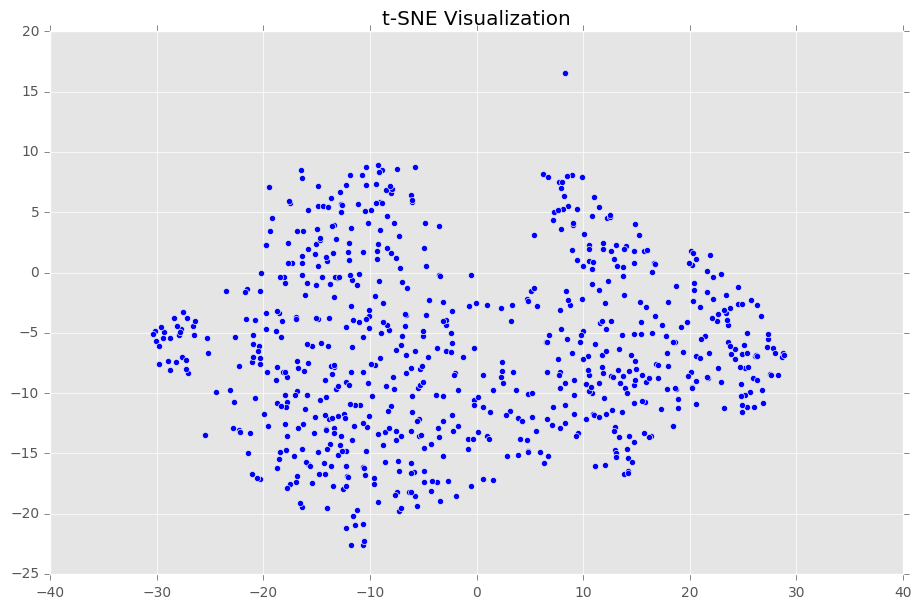

In [70]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=42)
Y = tsne.fit_transform(useData)
fig, ax1 = plt.subplots(1,1)
plt.scatter(Y[:, 0], Y[:, 1], c='Blue')
plt.title("t-SNE Visualization")

This magical two-dimensional projection of the data seems to imply that there's only one cluster. 